In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import pickle as pkl


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/CHIRPS/peru/CHIRPS_u200_correlation_5dRolling_1mm_peruBIG_1985-2018_diffs.nc')

In [5]:
g_on_era = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/aggs/daily_-40ALLkm2_DAY_onBIGERA_allyears.nc')

In [10]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [11]:
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [12]:
g_doypick = g_on_era['tir'].sel(time=((g_on_era['time.year']>=1985)&(g_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [13]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [14]:
## places

fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

regions = {
'equatorial' : [(-5,0), (-80,-76)],
'transition' : [(-8,-5), (-80,-75)],
'central' : [(-12,-8), (-80,-74)],
'southern' : [(-18,-15), (-75,-65)]}

In [15]:
corrdic = pkl.load(open(cnst.network_data + 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p', "rb"))
outarr_3 = corrdic['start_3d']
endarr_5 = corrdic['end_5d']

In [27]:
def dry_wet_gridsat_box(gridsat, doy_start, doy_end, dry=False, wet=False, region=None):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
    
    if region != None:
        box = regions[region]
    
        latbox = box[0]
        lonbox = box[1]
    else:
        region='RioSanta'
    
    if region in ['equatorial', 'transition']:
        hh=2000
    else:
        hh=3000
    
    if region != 'RioSanta':
        doys = doy_start.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0],latbox[1])).median(['latitude','longitude'])
        doye = doy_end.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0], latbox[1])).median(['latitude','longitude'])
        chirps_box = gridsat.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0], latbox[1])).where((gridsat['time.dayofyear']>=doys) | (gridsat['time.dayofyear']<=doye))/100#.mean(['latitude','longitude'])

        
    else:
        doys = doy_start.salem.roi(shape=sdf).median(['latitude','longitude'])
        doye = doy_end.salem.roi(shape=sdf).median(['latitude','longitude'])
        chirps_box = gridsat.salem.roi(shape=sdf).where((gridsat['time.dayofyear']>=doys) | (gridsat['time.dayofyear']<=doye))/100 #.mean(['latitude','longitude'])
        
#     f = plt.figure()
#     plt.pcolormesh(chirps_box.mean('time'))
    
    perc = np.percentile(chirps_box.values[np.isfinite(chirps_box)], [30,70])
    print(perc)
    
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box onset', doys.values, 'Date', dstr)
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doye.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box retreat', doye.values, 'Date', dstr)
    #ipdb.set_trace()
    ts_rainy = chirps_box
    
    #ch_perc = ts_rainy.groupby('time.year').quantile(0.99)
    
    if wet:
        pp = (ts_rainy.where(ts_rainy<=-40).count(['latitude','longitude'])/ts_rainy.count(['latitude','longitude'])).load()
        in_arr = pp>0.15 #ts_rainy.mean(['latitude','longitude']).where(pp>0.5)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        pp = (ts_rainy.where(ts_rainy>=0).count(['latitude','longitude'])/ts_rainy.count(['latitude','longitude'])).load()
        in_arr = pp>0.15 #ts_rainy.mean(['latitude','longitude']).where(
        #in_arr = (ts_rainy<perc[0])
        in_arr.values = (in_arr.values.astype(int))
        #ipdb.set_trace()
        tag = 'dry'
    #ipdb.set_trace()
    out_arr = np.zeros(ts_rainy.shape[0])


    if (np.isnan(doys) | np.isnan(doye)):
        ipdb.set_trace()

    ts = in_arr

    labels, numL = label(ts)

    u, inv = np.unique(labels, return_inverse=True)
    n = np.bincount(inv)

    inds_3 = u[(n>=3)&(n<5)&(u!=0)] ## min 3 days onset
    inds_5 = u[(n>=5)&(n<7)&(u!=0)] ## min 5 days breakdown
    inds_7 = u[(n>=7)&(n<9)&(u!=0)] ## min 5 days breakdown


    if len(inds_3)>0:
        for i in inds_3:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 3

    if len(inds_5)>0:
        for i in inds_5:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 5

    if len(inds_7)>0:
        for i in inds_7:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 7


    da = xr.DataArray(out_arr, coords=[ts_rainy['time']], dims=['time'])                    

    da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/'+tag+'_GRIDSATspells_1mm_3-7days_'+region+'_StartOfSpell_areaCheck.nc')
    #return da, ts_rainy, in_arr

In [32]:
def dry_wet_chirps_box(chirps, doy_start, doy_end, dry=False, wet=False, region=None):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
    
    if region != None:
        box = regions[region]
    
        latbox = box[0]
        lonbox = box[1]
    else:
        region='RioSanta'
    
    if region in ['equatorial', 'transition']:
        hh=2000
    else:
        hh=3000
    
    if region != 'RioSanta':
        doys = doy_start.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0],latbox[1])).median(['latitude','longitude'])
        doye = doy_end.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0], latbox[1])).median(['latitude','longitude'])
        chirps_box = chirps.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0], latbox[1])).where((chirps['time.dayofyear']>=doys) | (chirps['time.dayofyear']<=doye))#.mean(['latitude','longitude'])

        
    else:
        doys = doy_start.salem.roi(shape=sdf).median(['latitude','longitude'])
        doye = doy_end.salem.roi(shape=sdf).median(['latitude','longitude'])
        chirps_box = chirps.salem.roi(shape=sdf).where((chirps['time.dayofyear']>=doys) | (chirps['time.dayofyear']<=doye)) #.mean(['latitude','longitude'])
        
#     f = plt.figure()
#     plt.pcolormesh(chirps_box.mean('time'))
    
    perc = np.percentile(chirps_box.values[np.isfinite(chirps_box)], [30,70])
    
    perc = (0.1,1)
    print(perc)
    
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box onset', doys.values, 'Date', dstr)
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doye.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box retreat', doye.values, 'Date', dstr)
    #ipdb.set_trace()
    ts_rainy = chirps_box
    
    #ch_perc = ts_rainy.groupby('time.year').quantile(0.99)
    
    if wet:
        pp = (ts_rainy.where(ts_rainy>=1).count(['latitude','longitude'])/ts_rainy.count(['latitude','longitude'])).load()
        in_arr = pp>0.5 #ts_rainy.mean(['latitude','longitude']).where(pp>0.5)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        pp = (ts_rainy.where(ts_rainy<=0.5).count(['latitude','longitude'])/ts_rainy.count(['latitude','longitude'])).load()
        in_arr = pp>0.5
        #in_arr = (ts_rainy<perc[0])
        in_arr.values = (in_arr.values.astype(int))
        #ipdb.set_trace()
        tag = 'dry'
    #ipdb.set_trace()
    out_arr = np.zeros(ts_rainy.shape[0])


    if (np.isnan(doys) | np.isnan(doye)):
        ipdb.set_trace()

    ts = in_arr

    labels, numL = label(ts)

    u, inv = np.unique(labels, return_inverse=True)
    n = np.bincount(inv)

    inds_3 = u[(n>=3)&(n<5)&(u!=0)] ## min 3 days onset
    inds_5 = u[(n>=5)&(n<7)&(u!=0)] ## min 5 days breakdown
    inds_7 = u[(n>=7)&(n<9)&(u!=0)] ## min 5 days breakdown


    if len(inds_3)>0:
        for i in inds_3:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 3

    if len(inds_5)>0:
        for i in inds_5:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 5

    if len(inds_7)>0:
        for i in inds_7:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 7


    da = xr.DataArray(out_arr, coords=[ts_rainy['time']], dims=['time'])                    

    da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/'+tag+'_spells_1mm_3-7days_'+region+'_StartOfSpell_areaCheck.nc')
    #return da, ts_rainy, in_arr

In [29]:
def dry_wet_chirps_box_fixedThresh(chirps, doy_start, doy_end, dry=False, wet=False, region=None):
    
    pindex = 0
    
    tot =(365-doy_start)+doy_end
    
    if region != None:
        box = regions[region]
    
        latbox = box[0]
        lonbox = box[1]
    else:
        region='RioSanta'
    
    if region in ['equatorial', 'transition']:
        hh=2000
    else:
        hh=3000
    
    if region != 'RioSanta':
        doys = doy_start.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0],latbox[1])).median(['latitude','longitude'])
        doye = doy_end.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0], latbox[1])).median(['latitude','longitude'])
        chirps_box = chirps.where(topo_on_g>=hh).sel(longitude=slice(lonbox[0],lonbox[1]), latitude=slice(latbox[0], latbox[1])).where((chirps['time.dayofyear']>=doys) | (chirps['time.dayofyear']<=doye)).mean(['latitude','longitude'])

        
    else:
        doys = doy_start.salem.roi(shape=sdf).median(['latitude','longitude'])
        doye = doy_end.salem.roi(shape=sdf).median(['latitude','longitude'])
        chirps_box = chirps.salem.roi(shape=sdf).where((chirps['time.dayofyear']>=doys) | (chirps['time.dayofyear']<=doye)) #.mean(['latitude','longitude'])
        
#     f = plt.figure()
#     plt.pcolormesh(chirps_box.mean('time'))
    
    perc = np.percentile(chirps_box.values[np.isfinite(chirps_box)], [30,70])
    print(perc)
    
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box onset', doys.values, 'Date', dstr)
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doye.values - 1)+' days')
    dstr = date.strftime("%d/%m")
    print('Box retreat', doye.values, 'Date', dstr)
    #ipdb.set_trace()
    ts_rainy = chirps_box
    
    #ch_perc = ts_rainy.groupby('time.year').quantile(0.99)
    
    if wet:
        #pp = (ts_rainy.where(ts_rainy>=perc[1]).count(['latitude','longitude'])/ts_rainy.count(['latitude','longitude'])).load()
        in_arr = ts_rainy.where(pp>2)
        in_arr.values = (in_arr.values.astype(int))
        tag = 'wet'
    if dry:
        #pp = (ts_rainy.where(ts_rainy<=perc[0]).count(['latitude','longitude'])/ts_rainy.count(['latitude','longitude'])).load()
        in_arr = ts_rainy.where(pp<0.5) #pp>0.5 #ts_rainy.mean(['latitude','longitude']).where(
        #in_arr = (ts_rainy<perc[0])
        in_arr.values = (in_arr.values.astype(int))
        #ipdb.set_trace()
        tag = 'dry'
    #ipdb.set_trace()
    out_arr = np.zeros(ts_rainy.shape[0])


    if (np.isnan(doys) | np.isnan(doye)):
        ipdb.set_trace()

    ts = in_arr

    labels, numL = label(ts)

    u, inv = np.unique(labels, return_inverse=True)
    n = np.bincount(inv)

    inds_3 = u[(n>=3)&(n<5)&(u!=0)] ## min 3 days onset
    inds_5 = u[(n>=5)&(n<7)&(u!=0)] ## min 5 days breakdown
    inds_7 = u[(n>=7)&(n<9)&(u!=0)] ## min 5 days breakdown


    if len(inds_3)>0:
        for i in inds_3:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 3

    if len(inds_5)>0:
        for i in inds_5:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 5

    if len(inds_7)>0:
        for i in inds_7:
            pos = np.where(labels==i)
            out_arr[pos[0][0]] = 7


    da = xr.DataArray(out_arr, coords=[ts_rainy['time']], dims=['time'])                    

    da.to_netcdf('/media/ck/Elements/SouthAmerica/CHIRPS/'+tag+'_spells_1mm_3-7days_'+region+'_StartOfSpell_NoAreaCheck.nc')
    #return da, ts_rainy, in_arr

In [30]:
dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=True, wet=False)
dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=False, wet=True)

dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=True, wet=False, region='equatorial')
dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=False, wet=True, region='equatorial')

dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=True, wet=False, region='transition')
dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=False, wet=True, region='transition')

dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=True, wet=False, region='central')
dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=False, wet=True, region='central')

dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=True, wet=False, region='southern')
dry_wet_gridsat_box(g_doypick, outarr_3, endarr_5, dry=False, wet=True, region='southern')

[-14.31333333   0.        ]
Box onset 254.0 Date 11/09
Box retreat 152.0 Date 01/06
[-14.31333333   0.        ]
Box onset 254.0 Date 11/09
Box retreat 152.0 Date 01/06
[0. 0.]
Box onset 222.0 Date 10/08
Box retreat 202.0 Date 21/07
[0. 0.]
Box onset 222.0 Date 10/08
Box retreat 202.0 Date 21/07
[-2.548125  0.      ]
Box onset 247.0 Date 04/09
Box retreat 155.0 Date 04/06
[-2.548125  0.      ]
Box onset 247.0 Date 04/09
Box retreat 155.0 Date 04/06
[-25.45333333   0.        ]
Box onset 253.0 Date 10/09
Box retreat 113.0 Date 23/04
[-25.45333333   0.        ]
Box onset 253.0 Date 10/09
Box retreat 113.0 Date 23/04
[-43.925   0.   ]
Box onset 271.0 Date 28/09
Box retreat 92.0 Date 02/04
[-43.925   0.   ]
Box onset 271.0 Date 28/09
Box retreat 92.0 Date 02/04


In [33]:
dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, wet=False)
dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=False, wet=True)

dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, wet=False, region='equatorial')
dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=False, wet=True, region='equatorial')

dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, wet=False, region='transition')
dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=False, wet=True, region='transition')

dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, wet=False, region='central')
dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=False, wet=True, region='central')

dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=True, wet=False, region='southern')
dry_wet_chirps_box(chirps_doypick, outarr_3, endarr_5, dry=False, wet=True, region='southern')

(0.1, 1)
Box onset 254.0 Date 11/09
Box retreat 152.0 Date 01/06


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 254.0 Date 11/09
Box retreat 152.0 Date 01/06


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 222.0 Date 10/08
Box retreat 202.0 Date 21/07


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 222.0 Date 10/08
Box retreat 202.0 Date 21/07


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 247.0 Date 04/09
Box retreat 155.0 Date 04/06


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 247.0 Date 04/09
Box retreat 155.0 Date 04/06


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 253.0 Date 10/09
Box retreat 113.0 Date 23/04


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 253.0 Date 10/09
Box retreat 113.0 Date 23/04


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 271.0 Date 28/09
Box retreat 92.0 Date 02/04


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


(0.1, 1)
Box onset 271.0 Date 28/09
Box retreat 92.0 Date 02/04


/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [3]:
test = xr.open_dataarray('/media/ck/Elements/SouthAmerica/CHIRPS/wet_GRIDSATspells_1mm_3-7days_RioSanta_StartOfSpell_areaCheck.nc')

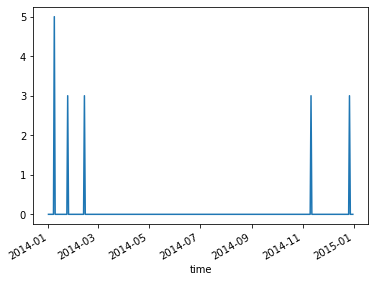

In [4]:
test.sel(time=test['time.year']==2014).plot()